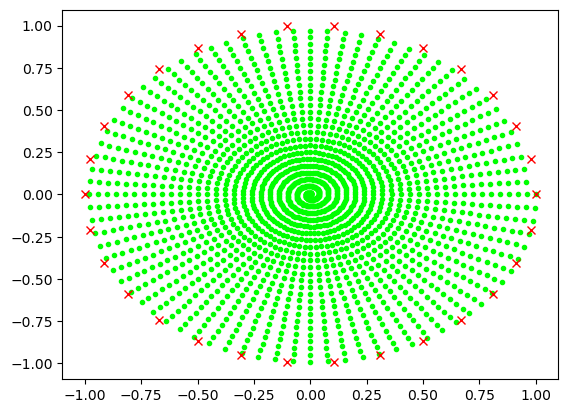

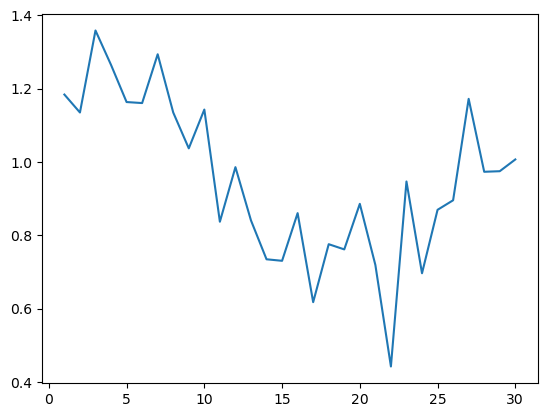

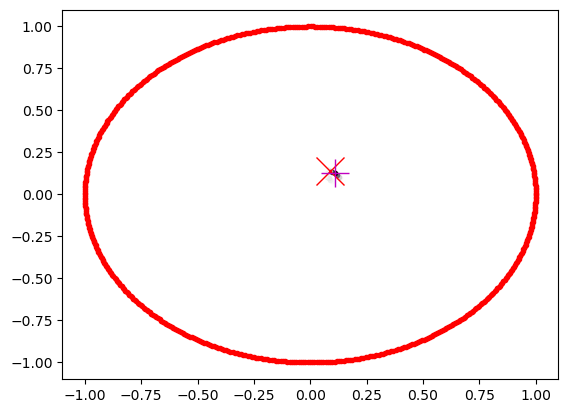

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fafaa12b5d0>

In [5]:
# using Random
using PyPlot

function conditional_prob(v,d1,d2)
    σ = 0.2
    p = (1/√(2*π*σ*σ)) * exp((-1/(2*σ)) * (v - (1/(d1*d1 + 0.1)) - (1/(d2*d2 + 0.1))))
    return p
end

function value(x,y,xs,ys)
    return 1/(0.1 + (x-xs)^2 + (y-ys)^2) #  determine distance of a sensor from a given point 
end


# explosion detector (using spiral coordinate system)
# define the coordinate system:
S=2000 # number of points on the spiral
rate=25 # angular rate of spiral

x=zeros(S); y=zeros(S)
for s=1:S
    theta=rate*2*pi*s/S;  r=s/S
    x[s]=r*cos(theta); y[s]=r*sin(theta)
end

for s=1:S
    plot(x[s],y[s],".",color=[0,1,0])
end


# define the locations of the detection stations on the surface
# Also define what value on each sensor would be generated by an explostion at internal location s
N=30 # number of stations
x_sensor=zeros(N); y_sensor=zeros(N)
v=zeros(S,N)
for sensor=1:N
    theta_sensor=2*pi*sensor/N
    x_sensor[sensor]=cos(theta_sensor); y_sensor[sensor]=sin(theta_sensor)
    for s=1:S
        v[s,sensor]=value(x[s],y[s],x_sensor[sensor],y_sensor[sensor]) # explosion value for some value function
    end
end


# show the location of the sensor
for sensor=1:N
    plot(x_sensor[sensor],y_sensor[sensor],"x",color="red")
end

# make a single explosion 
true_loc = rand(1:S)
x_true = x[true_loc]
y_true = y[true_loc]

# get noisy explosion data for a single explosion
sd = 0.1
values = zeros(N)
for sensor=1:N
    values[sensor] = value(x_true, y_true, x_sensor[sensor], y_sensor[sensor]) + sd*randn()
end

figure()
plot(1:N, values)

# Perform inference on these recorded values
# To do this we calculate the exponent, and then exponentiate. This apparantely prevnts under/overflow errors?

logp = zeros(S)
for s=1:S
    for sensor = 1:N
        logp[s] += -0.5*(values[sensor] - v[s,sensor])^2/(sd^2)
    end
end
p = exp.(logp.-maximum(logp))
p = p/sum(p) # normalize

maxp,maxind = findmax(p)

figure()
for s=1:S
    plot(x[s],y[s],".",color=(1-(p[s]/maxp))*[1,1,1])
end

for θ=0:0.01:2*π
    plot(cos(θ),sin(θ),".",color=[1,0,0])
end

plot(x_true, y_true,"rx", markersize=20, label="true")
plot(x[maxind],y[maxind],"m+",markersize = 20, label = "estimated most likely")

In [1]:
# using Random

function conditional_prob(v,d1,d2)
    σ = 0.2
    p = (1/√(2*π*σ*σ)) * exp((-1/(2*σ)) * (v - (1/(d1*d1 + 0.1)) - (1/(d2*d2 + 0.1))))
    return p
end

function value(x_sensor,y_sensor,x_true,y_true)
    return 1/(0.1 + (x_true-x_sensor)^2 + (y_true-y_sensor)^2)
end

# explosion detector (using spiral coordinate system)
# define the coordinate system:
S=2000 # number of points on the spiral
rate=25 # angular rate of spiral

x=zeros(S); y=zeros(S)
for s=1:S
    theta=rate*2*pi*s/S;  r=s/S
    x[s]=r*cos(theta); y[s]=r*sin(theta)
end


# define the locations of the detection stations on the surface
# Also define what value on each sensor would be generated by an explostion at internal location s
N=30 # number of stations
x_sensor=zeros(N); y_sensor=zeros(N)
v=zeros(S,N)
for sensor=1:N
    theta_sensor=2*pi*sensor/N
    x_sensor[sensor]=cos(theta_sensor); y_sensor[sensor]=sin(theta_sensor)
    for s=1:S
        v[s,sensor]=value(x_sensor[sensor],y_sensor[sensor],x[s],y[s]) # explosion value for some value function
    end
end


# make two explosions  
true_loc = rand(1:S, 2)
x1_true = x[true_loc[1]]
y1_true = y[true_loc[1]]

x2_true = x[true_loc[2]]
y2_true = y[true_loc[2]]

# get noisy explosion data for two explosions
sd = 4
values = zeros(N)
for sensor=1:N
    values[sensor] = value(x_sensor[sensor], y_sensor[sensor],x1_true, y1_true) + value(x_sensor[sensor], y_sensor[sensor],x2_true, y2_true) + sd*randn()
end

# Perform inference on these recorded values
# To do this we calculate the exponent, and then exponentiate. This apparantely prevnts under/overflow errors?

logp = zeros(S,S)
for s1=1:S
    for s2 = 1:S
        for sensor = 1:N
            logp[s1,s2] += -0.5*(values[sensor] - v[s1,sensor] - v[s2,sensor])^2/(sd^2)
        end
    end
end



In [4]:
using PyPlot


p = exp.(logp.-maximum(logp))
p = p/sum(p) # normalize

maxp, maxind = findmax(p)

figure()

p1 = sum(p,dims=2)

for s=1:S
    plot(x[s],y[s],".",color=(1-(p1[s]/maxp))*[1,1,1])
end

for θ=0:0.01:2*π
    plot(cos(θ),sin(θ),".",color=[1,0,0])
end

plot(x1_true, y1_true, "rx", markersize=20, label="true_1")
plot(x2_true, y2_true, "rx", markersize=20, label="true_2")

plot(x[maxind[1]],y[maxind[1]],"m+",markersize = 20, label = "estimated most likely 1")
plot(x[maxind[2]],y[maxind[2]],"m+",markersize = 20, label = "estimated most likely 2")

legend()

Figure(PyObject <Figure size 640x480 with 1 Axes>)

PyObject <matplotlib.legend.Legend object at 0x7fabedd0bd90>

In [7]:
v_data = zeros(30)
open("EarthquakeExerciseData.txt") do f
    for i in enumerate(eachline(f))
        v_data[i[1]] = parse(Float64,i[2])
    end
end

logp = zeros(S,S)
for s1=1:S
    for s2 = 1:S
        for sensor = 1:N
            logp[s1,s2] += -0.5*(v_data[sensor] - v[s1,sensor] - v[s2,sensor])^2/(sd^2)
        end
    end
end

p = exp.(logp.-maximum(logp))  # without taking away the maximum all the values are so small that you get 0 for everything.
p = p/sum(p) # normalize
maxp,maxind = findmax(p)

p1 = sum(p,dims=2)


#figure()
for s=1:S
    plot(x[s],y[s],".",color=(1-(p1[s]/maxp))*[1,1,1])
end

for θ=0:0.01:2*π
    plot(cos(θ),sin(θ),".",color=[1,0,0])
end

plot(x[maxind[1]],y[maxind[1]],"m+",markersize = 20, label = "estimated most likely 1")
plot(x[maxind[2]],y[maxind[2]],"m+",markersize = 20, label = "estimated most likely 2")

Figure(PyObject <Figure size 640x480 with 1 Axes>)

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fabea18bf10>

In [14]:
# Hypothesis testing
# 2 Explosion Hypothesis

logp2 = zeros(S,S)
for s1=1:S
    for s2 = 1:S
        for sensor = 1:N
            logp2[s1,s2] += -0.5*(v_data[sensor] - v[s1,sensor] - v[s2,sensor])^2/(sd^2)
        end
    end
end

# 1 explosion hypothesis
logp1 = zeros(S)
for s=1:S
    for sensor = 1:N
        logp1[s] += -0.5*(v_data[sensor] - v[s,sensor])^2/(sd^2)
    end
end


p2 = exp.(logp2.-maximum(logp2)) # this is a SxS probability map of the two explosion locations
p1 = exp.(logp1.-maximum(logp1))  # this is an S vector of the probability of a single explosion

logpH1 = log(2, sum(p1))
logpH2 = log(2, sum(p2))

7.628038484668616

In [15]:
print(logpH2 - logpH1)

5.704605044023168

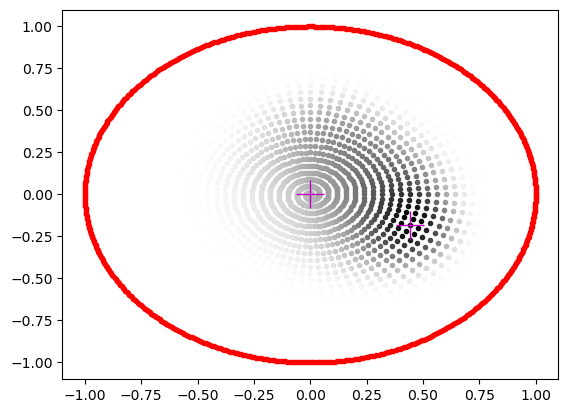

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc06c76d1d0>

In [5]:
# If the sensors sense the mean of the signals

function value_mean(x_sensor,y_sensor,x_true,y_true)
    return 0.5/(0.1 + (x_true-x_sensor)^2 + (y_true-y_sensor)^2)
end

v_data_mean = zeros(30)
open("EarthquakeExerciseMeanData.txt") do f
    for i in enumerate(eachline(f))
        v_data_mean[i[1]] = parse(Float64,i[2])
    end
end

x=zeros(S); y=zeros(S)
for s=1:S
    theta=rate*2*pi*s/S;  r=s/S
    x[s]=r*cos(theta); y[s]=r*sin(theta)
end

N=30 # number of stations
x_sensor=zeros(N); y_sensor=zeros(N)
v=zeros(S,N)

for sensor=1:N
    theta_sensor=2*pi*sensor/N
    x_sensor[sensor]=cos(theta_sensor); y_sensor[sensor]=sin(theta_sensor)
    for s=1:S
        v[s,sensor]=value_mean(x_sensor[sensor],y_sensor[sensor],x[s],y[s]) # explosion value for some value function
    end
end

logp = zeros(S,S)
for s1=1:S
    for s2 = 1:S
        for sensor = 1:N
            logp[s1,s2] += -0.5*(v_data_mean[sensor] - v[s1,sensor] - v[s2,sensor])^2/(sd^2)
        end
    end
end
logp = logp .= log(1/)
p = exp.(logp.-maximum(logp))  # without taking away the maximum all the values are so small that you get 0 for everything.
p = sum(p,dims=2)
p = p/sum(p) # normalize

maxp,maxind = findmax(p)

figure()
for s=1:S
    plot(x[s],y[s],".",color=(1-(p[s]/maxp))*[1,1,1])
end

for θ=0:0.01:2*π
    plot(cos(θ),sin(θ),".",color=[1,0,0])
end

plot(x[maxind[1]],y[maxind[1]],"m+",markersize = 20, label = "estimated most likely 1")
#plot(x[maxind[2]],y[maxind[2]],"m+",markersize = 20, label = "estimated most likely 1")


In [19]:
maximum(p)

0.0022106964651476867